#Computational drug discovery: part 2

##Exploratory Data Analysis

In [ ]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# Import libraries
import pandas as pd

In [ ]:
! wget -O genital_herpes_03_bioactivity_data_curated.csv https://raw.githubusercontent.com/AnVales/Drug-discovery/main/genital_herpes_03_bioactivity_data_curated.csv

--2021-09-02 20:54:45--  https://raw.githubusercontent.com/AnVales/Drug-discovery/main/genital_herpes_03_bioactivity_data_curated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21393 (21K) [text/plain]
Saving to: ‘genital_herpes_03_bioactivity_data_curated.csv’

genital_herpes_03_b 100%[===================>]  20.89K  --.-KB/s    in 0s      

2021-09-02 20:54:45 (60.6 MB/s) - ‘genital_herpes_03_bioactivity_data_curated.csv’ saved [21393/21393]



In [ ]:
bioactivity_data = pd.read_csv('genital_herpes_03_bioactivity_data_curated.csv')
bioactivity_data

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,100000.0,inactive
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,68000.0,inactive
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,100000.0,inactive
3,CHEMBL122296,CC(=O)O[C@@H]1[C@@H](C)C(=O)N1C(=O)NCc1ccccc1,6500.0,intermediate
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,27000.0,inactive
...,...,...,...,...
230,CHEMBL106921,Cc1csc2nc(Cc3cccc(NC(=O)c4ccccc4)c3)oc(=O)c12,1500.0,intermediate
231,CHEMBL107963,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NN)cc4)c3)oc(=O)c12,2400.0,intermediate
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,11000.0,inactive
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,61.0,active


In [ ]:
bioactivity_data.shape

(235, 4)

In [ ]:
# Delete rows with missing data
bioactivity_data_clean = bioactivity_data.dropna(how='any')
bioactivity_data_clean

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,100000.0,inactive
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,68000.0,inactive
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,100000.0,inactive
3,CHEMBL122296,CC(=O)O[C@@H]1[C@@H](C)C(=O)N1C(=O)NCc1ccccc1,6500.0,intermediate
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,27000.0,inactive
...,...,...,...,...
230,CHEMBL106921,Cc1csc2nc(Cc3cccc(NC(=O)c4ccccc4)c3)oc(=O)c12,1500.0,intermediate
231,CHEMBL107963,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NN)cc4)c3)oc(=O)c12,2400.0,intermediate
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,11000.0,inactive
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,61.0,active


In [ ]:
# As we have deleted rows we have to fix the index.
bioactivity_data_clean_index = bioactivity_data_clean.reset_index(drop=True)
bioactivity_data_clean_index

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,100000.0,inactive
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,68000.0,inactive
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,100000.0,inactive
3,CHEMBL122296,CC(=O)O[C@@H]1[C@@H](C)C(=O)N1C(=O)NCc1ccccc1,6500.0,intermediate
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,27000.0,inactive
...,...,...,...,...
230,CHEMBL106921,Cc1csc2nc(Cc3cccc(NC(=O)c4ccccc4)c3)oc(=O)c12,1500.0,intermediate
231,CHEMBL107963,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NN)cc4)c3)oc(=O)c12,2400.0,intermediate
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,11000.0,inactive
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,61.0,active


In [ ]:
# Check
bioactivity_data_clean_index[bioactivity_data_clean_index.isnull().any(1)]

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity


In [ ]:
# Rule-of-Five or Lipinski's Rule.
# Evaluation of the druglikeness of compounds.
# pharmacokinetic profile: Absorption, Distribution, Metabolism and Excretion (ADME)

# Molecular weight < 500 Dalton
# Octanol-water partition coefficient (LogP) < 5
# Hydrogen bond donors < 5
# Hydrogen bond acceptors < 10

In [ ]:
# Import libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
# Calculate descriptors
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
bioactivity_data_smiles_lipinski = lipinski(bioactivity_data_clean_index.canonical_smiles)
bioactivity_data_smiles_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,214.221,0.22590,1.0,4.0
1,228.248,0.61760,1.0,4.0
2,354.362,2.47780,2.0,4.0
3,276.292,1.26370,1.0,4.0
4,276.292,1.26370,1.0,4.0
...,...,...,...,...
230,376.437,4.40102,1.0,5.0
231,406.467,3.68662,3.0,7.0
232,151.165,1.69030,2.0,3.0
233,407.451,4.20212,3.0,7.0


In [ ]:
# We have Lipinski's properties now but we don't know to which it remains.  We need to link the data.
# bioactivity_data_smiles: molecule_chembl_id, standard_value, bioactivity, canonical_smiles
# bioactivity_data_smiles_lipinski: MW, LogP, NumHDonors, NumHAcceptors

In [ ]:
bioactivity_data_combined = pd.concat([bioactivity_data_clean_index,bioactivity_data_smiles_lipinski], axis=1)
bioactivity_data_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,100000.0,inactive,214.221,0.22590,1.0,4.0
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,68000.0,inactive,228.248,0.61760,1.0,4.0
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,100000.0,inactive,354.362,2.47780,2.0,4.0
3,CHEMBL122296,CC(=O)O[C@@H]1[C@@H](C)C(=O)N1C(=O)NCc1ccccc1,6500.0,intermediate,276.292,1.26370,1.0,4.0
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,27000.0,inactive,276.292,1.26370,1.0,4.0
...,...,...,...,...,...,...,...,...
230,CHEMBL106921,Cc1csc2nc(Cc3cccc(NC(=O)c4ccccc4)c3)oc(=O)c12,1500.0,intermediate,376.437,4.40102,1.0,5.0
231,CHEMBL107963,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NN)cc4)c3)oc(=O)c12,2400.0,intermediate,406.467,3.68662,3.0,7.0
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,11000.0,inactive,151.165,1.69030,2.0,3.0
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,61.0,active,407.451,4.20212,3.0,7.0


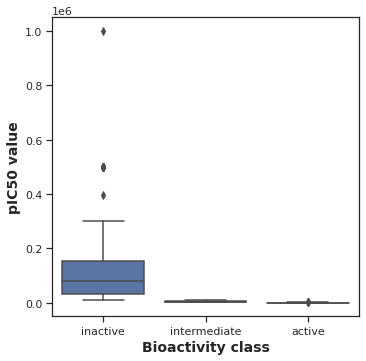

In [ ]:
# Box plots: pIC50 value
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'standard_value', data = bioactivity_data_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
# Convert IC50 to pIC50: 
# to allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50)


# This custom function pIC50() will accept a DataFrame as input and will:

# Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10^{-9}
# Take the molar value and apply -log10
# Delete the standard_value column and create a new pIC50 column


In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
# Values greater than 100,000,000 will be fixed as 100,000,000 otherwise the negative logarithmic value will become negative.
bioactivity_data_combined.standard_value.describe()

count        235.000000
mean       56209.900000
std       140630.107253
min            2.700000
25%          180.000000
50%         1400.000000
75%        33000.000000
max      1000000.000000
Name: standard_value, dtype: float64

In [ ]:
-np.log10( (10**-9)* 100000000 )

1.0

In [ ]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [ ]:
# Values greater than 100000000 are replaced by 100000000
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value',axis = 1)
        
    return x

In [ ]:
# The values in the standard_value column are normalized
bioactivity_data_combined_norm = norm_value(bioactivity_data_combined)
bioactivity_data_combined_norm

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,inactive,214.221,0.22590,1.0,4.0,100000.0
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,inactive,228.248,0.61760,1.0,4.0,68000.0
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,inactive,354.362,2.47780,2.0,4.0,100000.0
3,CHEMBL122296,CC(=O)O[C@@H]1[C@@H](C)C(=O)N1C(=O)NCc1ccccc1,intermediate,276.292,1.26370,1.0,4.0,6500.0
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,inactive,276.292,1.26370,1.0,4.0,27000.0
...,...,...,...,...,...,...,...,...
230,CHEMBL106921,Cc1csc2nc(Cc3cccc(NC(=O)c4ccccc4)c3)oc(=O)c12,intermediate,376.437,4.40102,1.0,5.0,1500.0
231,CHEMBL107963,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NN)cc4)c3)oc(=O)c12,intermediate,406.467,3.68662,3.0,7.0,2400.0
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,inactive,151.165,1.69030,2.0,3.0,11000.0
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,active,407.451,4.20212,3.0,7.0,61.0


In [ ]:
bioactivity_data_combined_norm.standard_value_norm.describe()

count        235.000000
mean       56209.900000
std       140630.107253
min            2.700000
25%          180.000000
50%         1400.000000
75%        33000.000000
max      1000000.000000
Name: standard_value_norm, dtype: float64

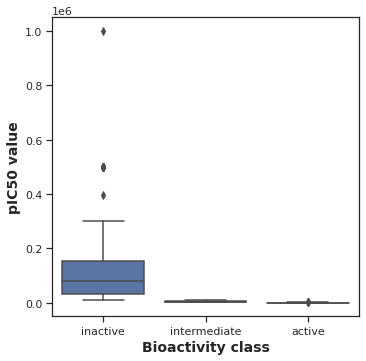

In [ ]:
# Box plots: pIC50 value
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'standard_value_norm', data = bioactivity_data_combined_norm)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
bioactivity_data_final = pIC50(bioactivity_data_combined_norm)
bioactivity_data_final

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,inactive,214.221,0.22590,1.0,4.0,4.000000
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,inactive,228.248,0.61760,1.0,4.0,4.167491
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,inactive,354.362,2.47780,2.0,4.0,4.000000
3,CHEMBL122296,CC(=O)O[C@@H]1[C@@H](C)C(=O)N1C(=O)NCc1ccccc1,intermediate,276.292,1.26370,1.0,4.0,5.187087
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,inactive,276.292,1.26370,1.0,4.0,4.568636
...,...,...,...,...,...,...,...,...
230,CHEMBL106921,Cc1csc2nc(Cc3cccc(NC(=O)c4ccccc4)c3)oc(=O)c12,intermediate,376.437,4.40102,1.0,5.0,5.823909
231,CHEMBL107963,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NN)cc4)c3)oc(=O)c12,intermediate,406.467,3.68662,3.0,7.0,5.619789
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,inactive,151.165,1.69030,2.0,3.0,4.958607
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,active,407.451,4.20212,3.0,7.0,7.214670


In [ ]:
bioactivity_data_final.pIC50.describe()

count    235.000000
mean       5.793012
std        1.478159
min        3.000000
25%        4.481486
50%        5.853872
75%        6.744727
max        8.568636
Name: pIC50, dtype: float64

In [ ]:
# Save all these data in a csv file
bioactivity_data_final.to_csv('genital_herpes_04_bioactivity_data_3class_pIC50.csv')

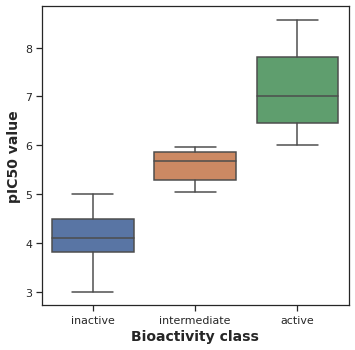

In [ ]:
# Box plots: pIC50 value
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'pIC50', data = bioactivity_data_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
# Remove the 'intermediate' bioactivity class
bioactivity_data_2class = bioactivity_data_final[bioactivity_data_final['bioactivity'] != 'intermediate']
bioactivity_data_2class

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL122071,CC(=O)O[C@@H]1CC(=O)N1C(=O)NC(C)C,inactive,214.221,0.22590,1.0,4.0,4.000000
1,CHEMBL124107,CCCCNC(=O)N1C(=O)C[C@H]1OC(C)=O,inactive,228.248,0.61760,1.0,4.0,4.167491
2,CHEMBL120853,C[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C...,inactive,354.362,2.47780,2.0,4.0,4.000000
4,CHEMBL333734,CC(=O)O[C@@H]1[C@H](C)C(=O)N1C(=O)NCc1ccccc1,inactive,276.292,1.26370,1.0,4.0,4.568636
5,CHEMBL74483,CC[C@@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(...,inactive,368.389,2.86790,2.0,4.0,4.000000
...,...,...,...,...,...,...,...,...
228,CHEMBL322676,Cc1csc2nc(Cc3cccc(NC(=O)c4cccc(NO)c4)c3)oc(=O)c12,active,407.451,4.20212,3.0,7.0,7.346787
229,CHEMBL104662,Cc1csc2nc(Cc3ccc(C(=O)c4ccccc4)cc3)oc(=O)c12,active,361.422,4.37972,0.0,5.0,6.096910
232,CHEMBL106641,CC(=O)c1cccc(NO)c1,inactive,151.165,1.69030,2.0,3.0,4.958607
233,CHEMBL108677,Cc1csc2nc(Cc3cccc(NC(=O)c4ccc(NO)cc4)c3)oc(=O)c12,active,407.451,4.20212,3.0,7.0,7.214670


In [ ]:
# Save all these data in a csv file
bioactivity_data_2class.to_csv('genital_herpes_05__bioactivity_data_2class_pIC50.csv')

In [ ]:
# Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

In [ ]:
# Import library
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

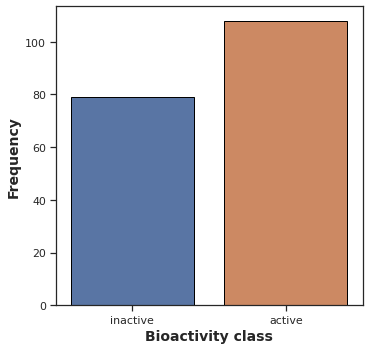

In [ ]:
# Frequency plot of the 2 bioactivity classes
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity', data=bioactivity_data_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

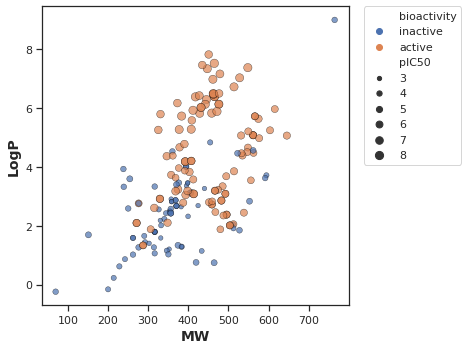

In [ ]:
# Scatter plot of MW versus LogP
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=bioactivity_data_2class, hue='bioactivity', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

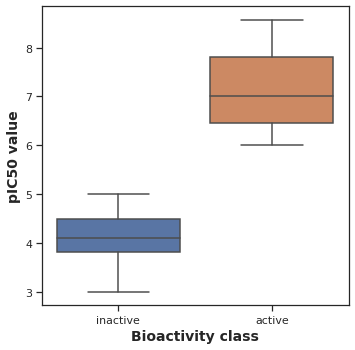

In [ ]:
# Box plots: pIC50 value
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'pIC50', data = bioactivity_data_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
# Statistical analysis | Mann-Whitney U Test
# It is used to test the heterogeneity of two ordinal samples.
# Difference between medians
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity']
  bioactivity_data_clean_index = bioactivity_data_2class[selection]
  active = bioactivity_data_clean_index[bioactivity_data_clean_index['bioactivity'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity']
  bioactivity_data_clean_index = bioactivity_data_2class[selection]
  inactive = bioactivity_data_clean_index[bioactivity_data_clean_index['bioactivity'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,8.754059e-32,0.05,Different distribution (reject H0)


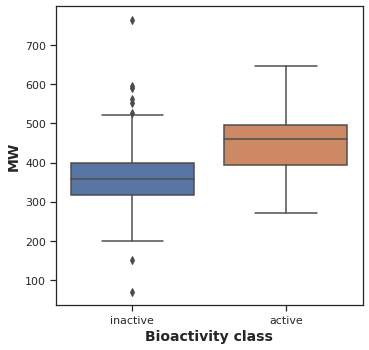

In [ ]:
# MW
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'MW', data = bioactivity_data_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1986.0,2.258070e-10,0.05,Different distribution (reject H0)


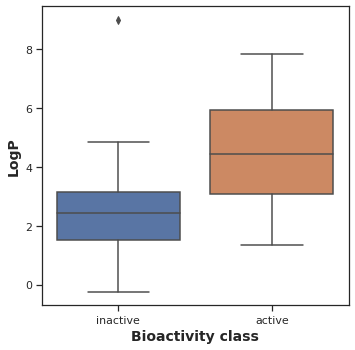

In [ ]:
# LogP
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'LogP', data = bioactivity_data_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1415.5,3.209282e-15,0.05,Different distribution (reject H0)


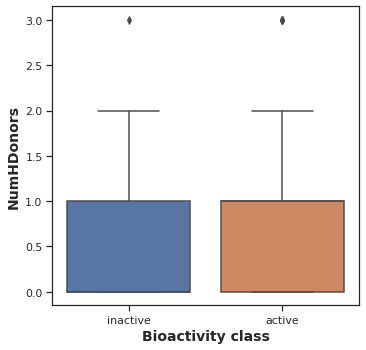

In [ ]:
# NumHDonors

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'NumHDonors', data = bioactivity_data_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2924.0,0.000038,0.05,Different distribution (reject H0)


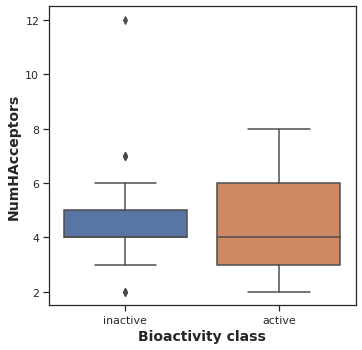

In [ ]:
# NumHAcceptors
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity', y = 'NumHAcceptors', data = bioactivity_data_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,4262.5,0.49662,0.05,Same distribution (fail to reject H0)


##Interpretation of Statistical Results

#Box Plots

#pIC50 values

Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

# Lipinski's descriptors
3 of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and inactives.

In [ ]:
# Save all
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_pIC50.csv (deflated 11%)
  adding: plot_MW.pdf (deflated 38%)
  adding: plot_MW_vs_LogP.pdf (deflated 11%)
  adding: genital_herpes_03_bioactivity_data_curated.csv (deflated 83%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: genital_herpes_05__bioactivity_data_2class_pIC50.csv (deflated 78%)
  adding: genital_herpes_04_bioactivity_data_3class_pIC50.csv (deflated 78%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: mannwhitneyu_MW.csv (deflated 7%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 9%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: plot_ic50.pdf (deflated 37%)
